# Tutorial: Introduction to Unsupervised Learning with a Focus on PCA

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F07_tutorial_unsupervised_learning_pca.ipynb)

Tutorial to the class [Introduction to Unsupervised Learning with a Focus on PCA](07_unsupervised_learning_pca.ipynb) based on the same case study as in [Tutorial: Regularization, Model Selection and Evaluation](05_tutorial_regularization_selection_evaluation.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Apply Principal Component Analysis (PCA) to climate data to analyze patterns of variability
- (Combine PCA reduction/$k$-means clustering to Ordinary Least Squares (OLS) to predict climate variables)
- (Use cross-validation to regularize the OLS with the number of retained Empirical Orthogonal Functions (EOFs) or clusters).
</div>

## Dataset presentation

- Input:
  - [Geopotential height](https://en.wikipedia.org/wiki/Geopotential_height) at 500hPa
    - Domain: North Atlantic
    - Spatial resolution: $0.5° \times 0.625°$
    - Time resolution: monthly
    - Period: 1980-2021
    - Units: m
    - Source: [MERRA-2 reanalysis](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/)
- Target:
  - Onshore wind capacity factors
    - Domain: Metropolitan France
    - Spatial resolution: regional mean
    - Time resolution: daily
    - Period: 2014-2021
    - Units:
    - Source: [RTE](https://opendata.reseaux-energies.fr/)

## Getting ready

### Reading the wind capacity factor and geopotential height data

We follow the same procedure as in [# Tutorial: Regularization, Model Selection and Evaluation](05_tutorial_regularization_selection_evaluation.ipynb).

In [22]:
# Import modules
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
plt.rc('font', size=14)

# Data directory
DATA_DIR = Path('data')

# Filename to geopotential height at 500hPa from MERRA-2 reanalysis
START_DATE = '19800101'
END_DATE = '20220101'
filename = 'merra2_analyze_height_500_month_{}-{}.nc'.format(START_DATE, END_DATE)
z500_label = 'Geopotential height (m)'
# Set data directory
data_dir = Path('data')

# Set keyword arguments for pd.read_csv
kwargs_read_csv = dict(index_col=0, parse_dates=True) 

# Define electricity demand filepath and label
windcf_filename = 'reseaux_energies_capacityfactor_wind-onshore.csv'
windcf_filepath = Path(data_dir, windcf_filename)
windcf_label = 'Wind capacity factor'

# Read windcf data with pandas                                                                                                                                                
df_windcf_daily = pd.read_csv(windcf_filepath, **kwargs_read_csv)

# Select domain
# REGION_NAME = 'Bretagne'
REGION_NAME = 'National'
if REGION_NAME == 'National':
    df_windcf_daily_reg = df_windcf_daily.mean('columns')
    df_windcf_daily_reg.name = REGION_NAME
else:
    df_windcf_daily_reg = df_windcf_daily[REGION_NAME]

# Resample wind capacity factor from daily to monthly means
df_windcf_reg = df_windcf_daily_reg.resample('MS').mean()

> ***Question***
> - Read the geopotential height data using `xarray.load_dataset` and print it.

In [23]:
ds = xr.load_dataset(DATA_DIR / filename)


> ***Question (optional)***
> - Coarsen the grid resolution of the geopotential height field to reduce the number of variables.

In [24]:
z500_name = 'height_500'                                                                                                                                                     
da_z500 = ds[z500_name]




### Representing the first moments of the geopotential height field

> ***Question***
> - Compute the mean and the variance of the geopotential height with the `mean` and `var` methods.
> - Plot the mean with the `plot` method.
> - Do a filled-contour plot of the variance with the `plot.contourf` method.

In [25]:
da_z500_mean = da_z500.mean(dim='time')
da_z500_var = da_z500.var(dim='time')
da_z500_anom = da_z500 - da_z500_mean



> ***Question***
> - Plot the variance of the geopotential height.

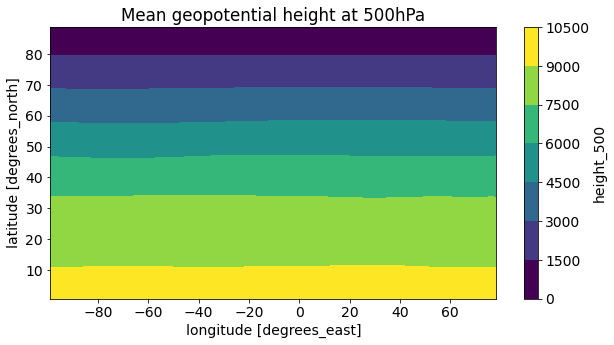

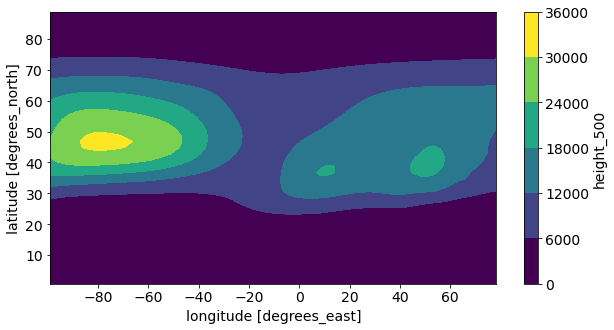

In [26]:
plt.figure(figsize=(10, 5))
da_z500_mean.plot.contourf()

plt.title('Mean geopotential height at 500hPa')
plt.show()
plt.figure(figsize=(10, 5))
plt.title('Variance of geopotential height at 500hPa')
da_z500_var.plot.contourf()
plt.show()

> ***Question***
> - Scale the geopotential-height deviations to account for variations in the area represented by each grid point.
> - Plot the variance of the scaled geopotential height.
> - Qualitatively describe the mean and variance of the geopotential height.

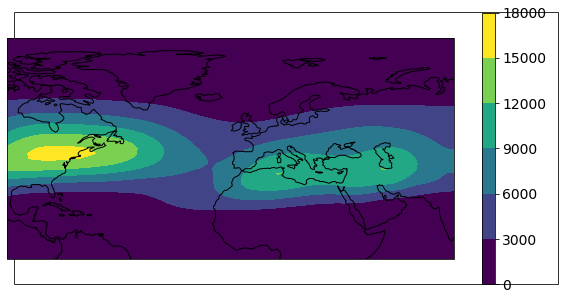

In [27]:
import cartopy
coef=np.cos(np.deg2rad(da_z500['lat']))
da_z500_anom_weighted = da_z500_anom * coef
da_z500_weighted_var= da_z500_anom_weighted.var('time')
proj=cartopy.crs.PlateCarree()

fig,ax=plt.subplots(figsize=(10,5),subplot_kw={'projection':proj})
ax=plt.axes(projection=proj)
da_z500_weighted_var.plot.contourf(ax=ax,transform=proj)
ax.coastlines()

Answer:

## PCA of the geopotential height field

> ***Question***
> - Estimate the covariance matrix of the scaled geopotential height using the `stack` method of data arrays.

In [28]:
# answer cell
da_stack=da_z500_anom_weighted.stack(latlon=('lat','lon'))
X=da_stack.values

print(X.shape)
sigma=np.cov(da_stack.T)
print(sigma.shape)

(504, 3240)
(3240, 3240)


In [29]:
lam,V=np.linalg.eigh(sigma)
print(lam.shape)
print(V.shape)

(3240,)
(3240, 3240)


> ***Question***
> - Compute EOFs and corresponding variances using `np.linalg.eigh`.

> ***Question***
> - Sort the EOFs and corresponding variances by decreasing variances.
> - Plot the fraction of variance "explained" by the leading 20 EOFs.
> - Interpret your results.

In [30]:
# answer cell
idx=np.argsort(lam)[::-1]
lam,V=lam[idx],V[:,idx]



Answer: 

> ***Question***
> - Plot the leading EOF on a map.
> - To what physical phenomenon could this pattern be associated to?

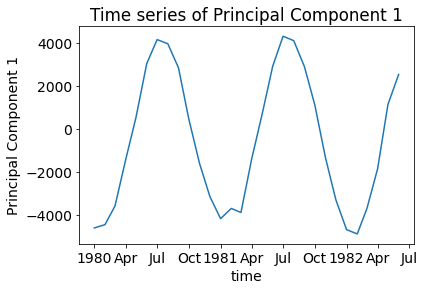

In [31]:
a0=X@V[:,0]
da_a0=xr.DataArray(a0,coords=[da_z500.coords['time']])
da_a0[0:30].plot()
plt.title('Time series of Principal Component 1')
plt.ylabel('Principal Component 1')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

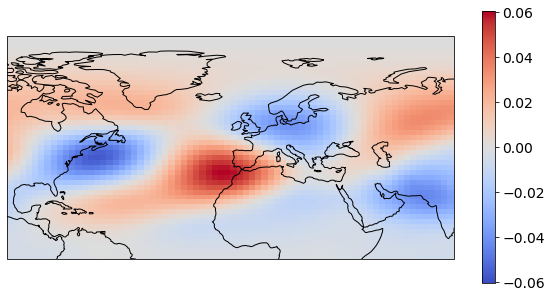

In [47]:
da_v0=xr.DataArray(V[:,4],coords=[da_stack.coords['latlon']],dims=['latlon']).unstack('latlon')
fig, ax= plt.subplots(figsize=(10,5),subplot_kw={'projection':proj})

da_v0.plot(
    ax=ax,
    transform=proj,
    cmap='coolwarm'
)
ax.coastlines()
plt.show

Answer: 

> ***Question***
> - Compute the principal component associated with the leading EOF.
> - Compare its variance to the corresponding eigenvalue and explain your result.
> - Plot this principal component.
> - Confirm or reconsider you previous answer on the physical phenomenon that could be associated to the leading EOF.

In [33]:
# answer cell


Answer: 

### Dealing with the seasonal cycle

> ***Question (optional)***
> - Use the `scipy.signal.welch` to estimate the Power Spectral Density (PSD) of the leading principal component and plot it.
> - Confirm or reconsider you previous answer on the physical phenomenon that could be associated to the leading EOF.

In [34]:
# answer cell


> ***Question***
> - Compute the seasonal cycle of the geopotential height (averages over all years of the same month of the year for each month) with the `groupby` of data arrays.
> - Plot all 12 months. You can use the `col` option of the `plot` method of data arrays.
> - Also plot the variance of the seasonal cycle on a map.
> - Confirm or reconsider you previous answer on the physical phenomenon that could be associated to the leading EOF.

In [35]:
# answer cell


Answer: 

> ***Question***
> - Compute seasonal anomalies (deviations from the seasonal cycle) of the geopotential height with `groupby`.
> - Plot the variance of the seasonal anomalies on a map.
> - How does it compare to the variance of the data with the seasonal cycle?

In [36]:
# answer cell


Answer:

### Representing and interpreting the EOFs

> ***Question***
> - Estimate the covariance matrix of the anomalies (with the seasonal cycle subtracted).
> - Compute the EOFs and corresponding variances.
> - Plot the explained variances associated with the EOFs together with the cumulative sum of the explained variances.
> - What is the minimum number of EOFs that one needs to keep to explain at least 90% of the variance.

In [37]:
# answer cell


Answer:

> ***Question***
> - Plot the leading 4 EOFs and principal components.
> - Can you associate these patterns to known climate phenomena?

In [38]:
# answer cell


### Reconstructing the geopotential height field from the EOFs and PCs

Answer: 

> ***Question***
> - Reconstruct the inputs from the leading 4 EOFs only.
> - Compare the original time series at a few arbitrary locations to the corresponding reconstructed time series.
> - Plot the variance of the reconstruction on a map.
> - Same question but keeping more EOFs
> - Interpret your results in terms of filtering.

In [39]:
# answer cell


Answer: 

## Using PCA to extract features for prediction

> ***Question (optional)***
> - Design a linear model that best predicts present (not future) wind capacity factors in `data/reseaux_energies_capacityfactor_wind-onshore.csv` using geopotential-height principal components as inputs. To do, use cross-validation to regularize based on the number of leading principal components retained.

In [40]:
# answer cell


> ***Question (optional)***
> - Use $k$-means clustering with `sklearn.cluster.KMeans` to detect "atmospheric regimes" from the geopotential-height data and compare the result to the EOFs obtained above.
> - Design a linear model as above but based on clusters rather than EOFs.

In [41]:
# answer cell


***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>